In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 90kB/s 


In [ ]:
import datetime
import gc
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
#ファイル読み取り
X_train = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_train.csv', index_col=0)
X_validation = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_validation.csv', index_col=0)
X_test = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_test.csv', index_col=0)

label = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_train.csv', index_col=0)
Y_train = label['Y']
catboost_train_pred = label['catboost']
xgb_train_pred = label['xgb']

label = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_val.csv', index_col=0)
Y_validation = label['Y']
catboost_val_pred = label['catboost']
xgb_val_pred = label['xgb']

label = pd.read_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_test.csv', index_col=0)
catboost_test_pred = label['catboost']
xgb_test_pred = label['xgb']

del label

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

##Modeling the data

###Catboost

In [ ]:
#Integer features (used by catboost model)
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')

In [ ]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354201
0:	learn: 0.8027343	test: 0.8518191	best: 0.8518191 (0)	total: 4.49s	remaining: 37m 20s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7964944158
bestIteration = 10

Shrink model to first 11 iterations.


In [ ]:
gc.collect()

603

In [ ]:
print('Model params:', catboost_model.get_params())

In [ ]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

In [ ]:
#delete unnecessary data
del int_features
del cat_features
del catboost_model
del feature_score

In [ ]:
print(sys.getsizeof(catboost_train_pred))
print(sys.getsizeof(catboost_val_pred))
print(sys.getsizeof(catboost_test_pred))
print(sys.getsizeof(X_train))
print(sys.getsizeof(X_validation))
print(sys.getsizeof(X_test))
print(sys.getsizeof(ax))

In [ ]:
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

####XGBoost

In [ ]:
xgb_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1','item_cnt_shifted2',
                'item_cnt_shifted3', 'shop_mean', 'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[06:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:35] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.927331	validation_1-rmse:0.918091
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.67168	validation_1-rmse:0.789823
Stopping. Best iteration:
[18]	validation_0-rmse:0.674448	validation_1-rmse:0.788447



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

In [ ]:
#feature importance
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

###Random forest

In [ ]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

How random forest performed with this "prediction x labal" plot.

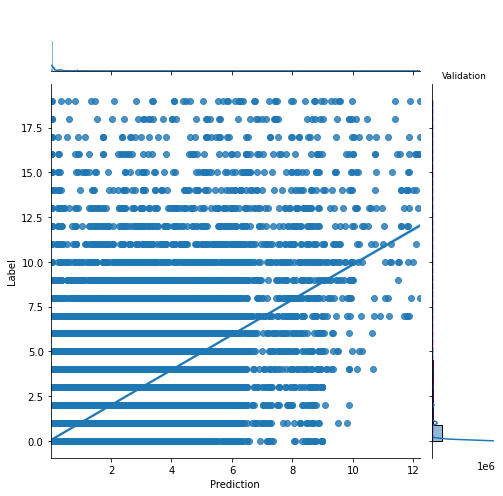

In [ ]:
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

##Linear models

###Linear Regression

In [ ]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

Normalizing features

In [ ]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
#train dataに合わせてスケーリング
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [ ]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7223078559288567
Validation rmse: 0.7669131020489564


how linear regression performed with this "prediction x label" plot.¶

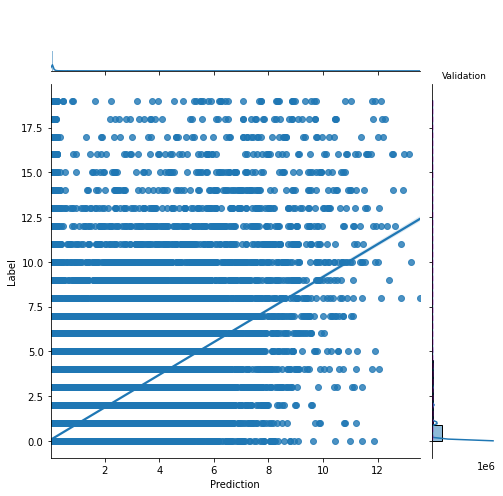

In [ ]:
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

##Clustering models


###KNN Regressor

In [ ]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']



knn_train = X_train[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

Normalizing features

In [ ]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train)

In [ ]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.47446031719480247
Validation rmse: 3.1813952771422493


In [ ]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

In [ ]:
#ファイル出力
X_train.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_train.csv')
X_validation.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_validation.csv')
X_test.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/x_test.csv')
label_train = pd.DataFrame({'Y':Y_train,
                            'catboost': catboost_train_pred,
                            'xgb': xgb_train_pred,
                            'random_forest':rf_train_pred,
                            'linear_regression':lr_train_pred,
                            'knn': knn_train_pred})
label_train.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_train.csv')
del label_train

label_val = pd.DataFrame({'Y':Y_validation,
                            'catboost': catboost_val_pred,
                            'xgb': xgb_val_pred,
                            'random_forest':rf_val_pred,
                            'linear_regression':lr_val_pred,
                            'knn': knn_val_pred})
label_val.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_val.csv')
del label_val

label_test = pd.DataFrame({'catboost': catboost_test_pred,
                           'xgb': xgb_test_pred,
                           'random_forest':rf_test_pred,
                           'linear_regression':lr_test_pred,
                            'knn': knn_test_pred})
label_test.to_csv('drive/MyDrive/Colab Notebooks/kaggle/PredictFutureSales/data/label_test.csv')
del label_test

##Create new datasets with the predictions from first level models.

In [ ]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

##Ensembling

2nd leval model as a linear regression

In [ ]:
meta_model = LinearRegression(n_jobs=-1)

Trained on validation set using the 1st level models predictions as features

In [ ]:
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

Make predictions on test set using the 1st level models predictions as features

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level.test)

Ensemble model metrics on validation set

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

How the meta model performed with this 'prediction x label plot'

In [ ]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')